![](img/dask_horizontal.svg)                                

# Карманная артиллерия датасаенса

У Dask хорошая документация http://dask.readthedocs.io/en/latest/

Метью делает отличные слайды http://matthewrocklin.com/slides/dask-short.html


## План сражения
1. История вопроса
2. Основные компоненты
3. Примеры
4. Экосистема
5. See also - Blaze, Numba, Toolz

## Зачем

"Сообщество оказалось поймано в ловушку вычислений на одном процессоре и в памяти одного компьютера".

"Медианный размер кластера Dask - один компьютер".

[Matthew Rocklin](https://matthewrocklin.com/)
    

## Проблемы Pandas:
- данные должны умещаться в память
- все работает в один поток. Параллельная обработка - руками

## Решение Dask
* обертки для работы с данными, не умещающимися в память
* автоматическая параллелизация вычислений.
* просто

## History
 * Parallel NumPy algorithms
 * Computational task scheduler (single machine)
 * Dataframes and Bags
 * Custom computations (dask.delayed)
 * Distributed scheduler
 * Asynchronous workflows (concurrent.futures)
 * Increased diversity of workloads
    * Auto-scaling
    * Multi-client collaboration
    * Other languages (Julia client exists)
    * Non-task-based APIs

## Батарейки прилагаются
 * Dask DataFrame - как pandas
 * Dask Array - как numpy
 * Dask Bag - как iterators, Toolz, PySpark
 * Dask-ML
   * distributed-joblib
   * dask-оптимизированные алгоритмы
   * dask-searchcv
   * dask-xgboost
   * dask-tensorflow
 * Dask-Distributed
 * Dask Delayed
 * concurrent.futures

## Dask DataFrame
```
import pandas as pd                     import dask.dataframe as dd
df = pd.read_csv('2015-01-01.csv')      df = dd.read_csv('2015-*-*.csv')
df.groupby(df.user_id).value.mean()     df.groupby(df.user_id).value.mean().compute()
```

## Dask Array
```
import numpy as np                       import dask.array as da
f = h5py.File('myfile.hdf5')             f = h5py.File('myfile.hdf5')
x = np.array(f['/small-data'])           x = da.from_array(f['/big-data'], chunks=(1000, 1000))
x - x.mean(axis=1)                       x - x.mean(axis=1).compute()
```

## Dask Bag
```
import dask.bag as db
b = db.read_text('2015-*-*.json.gz').map(json.loads)
b.pluck('name').frequencies().topk(10, lambda pair: pair[1]).compute()
```

## Dask Delayed
```
from dask import delayed
L = []
for fn in filenames: 
    data = delayed(load)(fn)
    L.append(delayed(process)(data)) 

result = delayed(summarize)(L)
result.compute()
```

## concurrent.futures
```
from dask.distributed import Client
client = Client('scheduler:port')

futures = []
for fn in filenames:
    future = client.submit(load, fn)
    futures.append(future)

summary = client.submit(summarize, futures)
summary.result()
```

## Примеры

In [1]:
import dask.dataframe as dd
import dask
import pandas as pd
from IPython.display import display
import glob

In [2]:
column_names = ['ip', 'ts', 'request', 'code', 'fsize', 't1', 't2', 'server']
params = dict(sep='\t', header=None, names=column_names, dtype={'t2': 'object'})

### Есть тут у меня один файл

In [7]:
!wc -l data2/fastimage.log.1

1860793 data2/fastimage.log.1


In [14]:
%%time
df2 = pd.read_csv('data2/fastimage.log.1', **params)
print(df2.groupby(by='ip')['fsize'].sum().sort_values().tail())

ip
91.192.148.252     7950486721
92.242.34.58       7960177558
109.171.20.123     9410222194
37.9.68.172       34845595493
37.9.68.181       50381208617
Name: fsize, dtype: int64
CPU times: user 3.36 s, sys: 156 ms, total: 3.52 s
Wall time: 3.52 s


### Кстати, что там? Логи запросов к серверу

In [11]:
df2.head()

ip                            ts  \
0     85.90.99.170  [02/Apr/2018:06:25:28 +0300]   
1      37.9.68.172  [02/Apr/2018:06:25:28 +0300]   
2  213.180.200.143  [02/Apr/2018:06:25:28 +0300]   
3   178.154.148.12  [02/Apr/2018:06:25:28 +0300]   
4    5.255.206.244  [02/Apr/2018:06:25:28 +0300]   

                                             request  code   fsize     t1  \
0      GET /download/catalog/ts161021_1.png HTTP/1.1   200   13881  0.100   
1  GET /download/catalog/tb298681_3.png?20180414 ...   200  109503  0.744   
2  GET /download/catalog/tb500170_1.png?20180414 ...   200  150901  0.300   
3  GET /download/catalog/tb155521_1.png?20180414 ...   200  293674  0.500   
4  GET /download/catalog/tb304173_1.png?20180414 ...   200  224071  0.300   

      t2              server  
0  0.100  185.22.234.73:2085  
1  0.744  185.22.234.73:2086  
2  0.300  185.22.234.73:2086  
3  0.500  185.22.234.73:2086  
4  0.300  185.22.234.73:2086

### Dask DataFrame быстрее

In [19]:
%%time
df = dd.read_csv('data2/fastimage.log.1', **params)
r = df.groupby(by='ip')['fsize'].sum().compute().sort_values().tail()

CPU times: user 4.66 s, sys: 332 ms, total: 4.99 s
Wall time: 2.82 s


### Но не всегда

In [20]:
%%time
df = dd.read_csv('data2/fastimage.log.1', **params)
r = df.groupby(by='ip')['fsize'].sum().compute(get=dask.get).sort_values().tail()

CPU times: user 3.56 s, sys: 244 ms, total: 3.81 s
Wall time: 3.8 s


Если отключить асинхронность, то выходит так же, если не медленнее. Удобно при отладке

По умолчанию используется планировщик dask.threaded.get на потоках

dask.array and dask.dataframe use the threaded scheduler by default
dask.bag uses the multiprocessing scheduler by default.

* __dask.threaded.get__: a scheduler backed by a thread pool
* __dask.multiprocessing.get__: a scheduler backed by a process pool
* __dask.get__: a synchronous scheduler, good for debugging
* __distributed.Client.get__: a distributed scheduler for executing graphs

На процессах получится немного лучше, чем на потоках

### И красиво сделаем pandas!

In [22]:
%%time
df = dd.read_csv('data2/fastimage.log.1', **params)
df.head()

CPU times: user 928 ms, sys: 52 ms, total: 980 ms
Wall time: 977 ms


In [23]:
%%time
df2 = pd.read_csv('data2/fastimage.log.1', **params)
e = df2.head()

CPU times: user 3.3 s, sys: 144 ms, total: 3.44 s
Wall time: 3.45 s


Dask прочитает и разберет 5 строчек, а pandas - все.
### У нас есть много файлов!

In [26]:
params = dict(sep='\t', header=None, names=column_names, dtype={'t2': 'object'}, compression='gzip')
!ls data3

fastimage.log.10.gz  fastimage.log.2.gz  fastimage.log.7.gz
fastimage.log.11.gz  fastimage.log.3.gz  fastimage.log.8.gz
fastimage.log.12.gz  fastimage.log.4.gz  fastimage.log.9.gz
fastimage.log.13.gz  fastimage.log.5.gz
fastimage.log.14.gz  fastimage.log.6.gz


In [27]:
%%time
df = dd.read_csv('data3/*', blocksize=None, **params)
e = df.head()

CPU times: user 3.34 s, sys: 244 ms, total: 3.58 s
Wall time: 3.58 s


### А что Pandas?

In [29]:
%%time
df2 = pd.concat([pd.read_csv(fn, **params) for fn in glob.glob('data3/*')])
e = df2.head()

CPU times: user 44.2 s, sys: 2 s, total: 46.2 s
Wall time: 46.1 s


### Ну это было нечестно
Попробуем группировку

In [32]:
%%time
df = dd.read_csv('data3/*', blocksize=None, **params)
r = df.groupby(by='ip')['fsize'].sum().compute().sort_values().tail()

CPU times: user 1min 1s, sys: 5.27 s, total: 1min 7s
Wall time: 37 s


In [33]:
%%time
df2 = pd.concat([pd.read_csv(fn, **params) for fn in glob.glob('data3/*')])
r = df2.groupby(by='ip')['fsize'].sum().sort_values().tail()

CPU times: user 47.2 s, sys: 2.93 s, total: 50.2 s
Wall time: 50.1 s


Неплохо. Всего на 20% хуже по времени. Но значительно хуже по памяти!

## Ленивые вычисления и параллельность сама собой

In [3]:
from dask import delayed
import time

In [4]:
@delayed
def compute(x):
    time.sleep(0.1)
    return x*x

def scompute(x):
    time.sleep(0.1)
    return x*x

@delayed
def combine(sq):
    return sum(sq)

def scombine(sq):
    return sum(sq)


In [5]:
%%time
e = sum(scompute(x) for x in range(10))
print(e)

285
CPU times: user 0 ns, sys: 4 ms, total: 4 ms
Wall time: 1 s


In [18]:
!free -m

              total        used        free      shared  buff/cache   available
Память:       32049        1886       28028          70        2134       29659
Подкачка:       32366           0       32366


In [6]:
%%time
e = sum(compute(x) for x in range(10))
print(e.compute())

285
CPU times: user 20 ms, sys: 4 ms, total: 24 ms
Wall time: 317 ms


## Что это было?

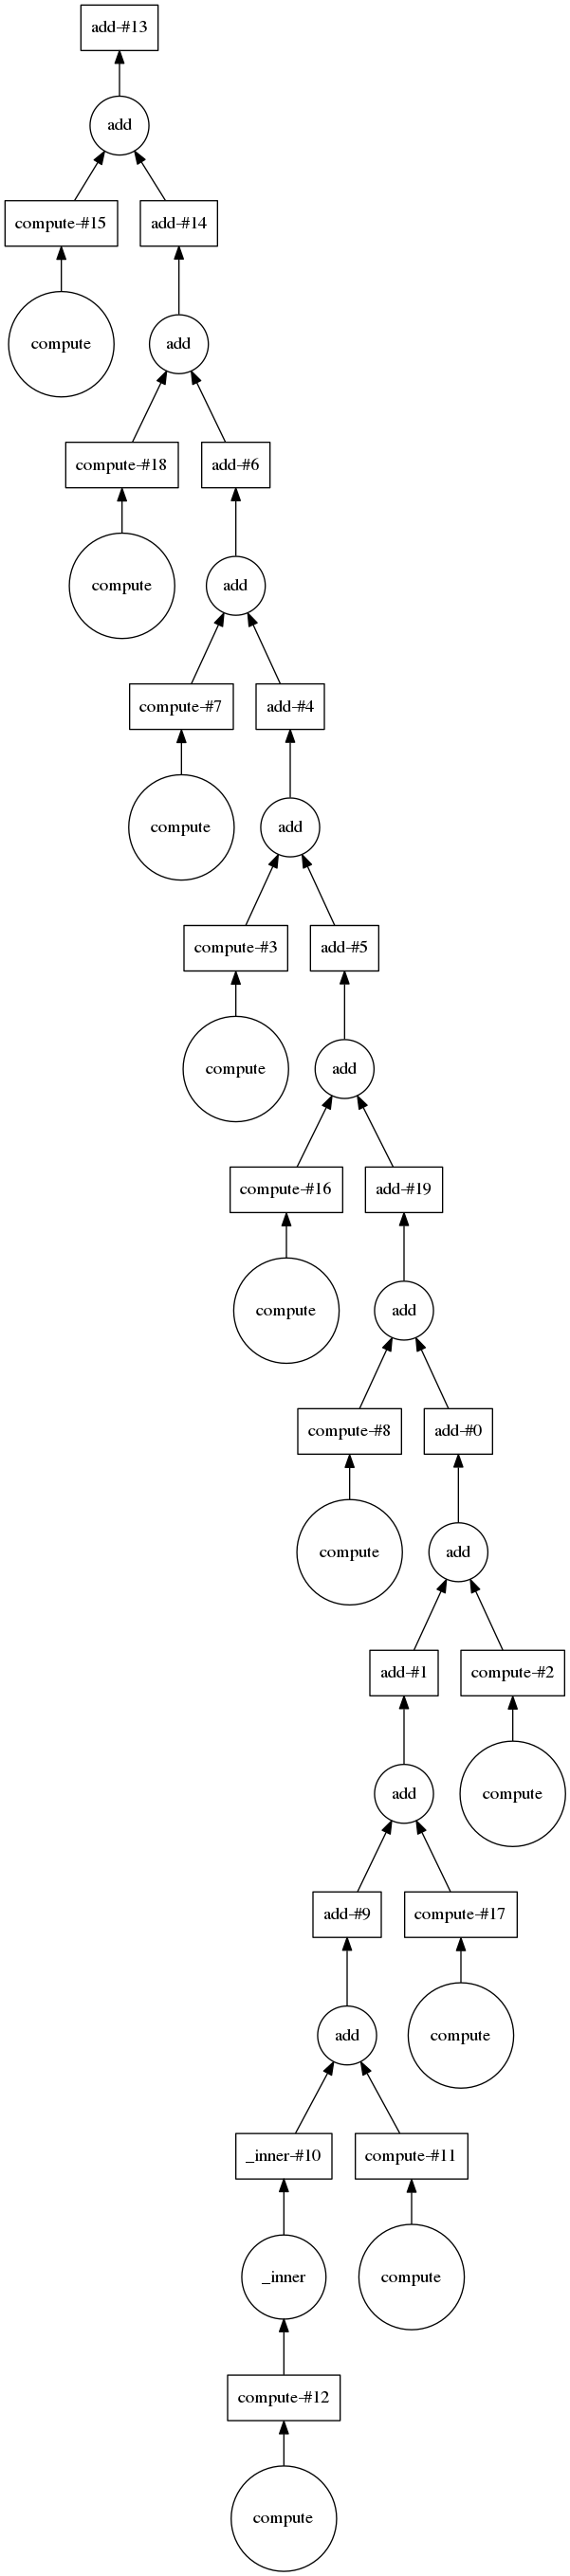

In [7]:
e.visualize()

### Надо быть последовательно ленивыми

In [8]:
%%time
e = delayed(sum)(compute(x) for x in range(10))
print(e.compute())

285
CPU times: user 16 ms, sys: 0 ns, total: 16 ms
Wall time: 313 ms


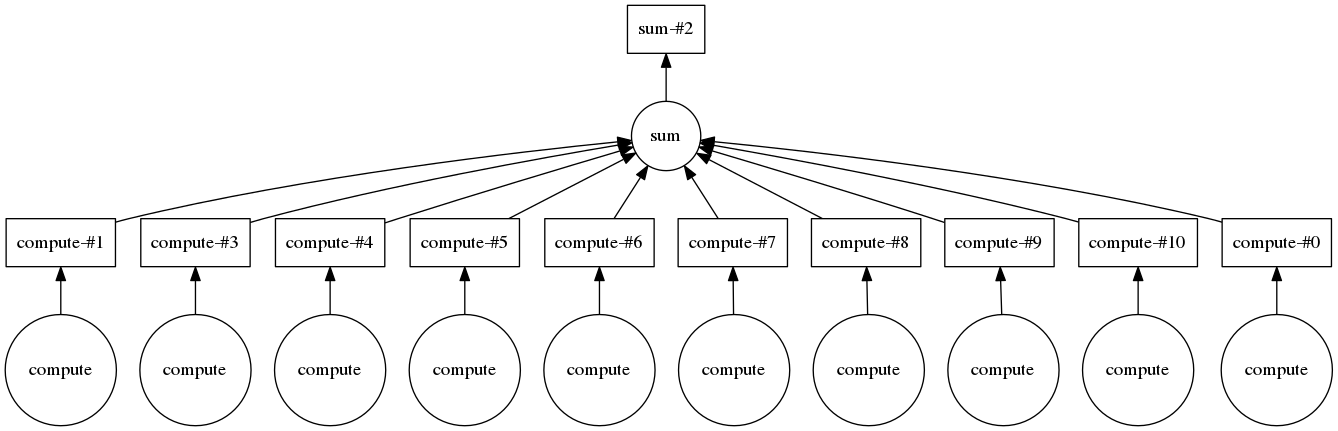

In [9]:
e.visualize()

### Мне так больше нравится. А что еще умеем?

In [10]:
%%time
# По умолчанию у локальных планировщиков 4 воркера. Можно попробовать в 10 потоков
e = delayed(sum)(compute(x) for x in range(10))
print(e.compute(num_workers=10))

285
CPU times: user 12 ms, sys: 0 ns, total: 12 ms
Wall time: 110 ms


### Наверное, быстрее уже не выйдет.
А давайте попробуем на кластере!

In [12]:
from distributed import Client, LocalCluster

In [13]:
cluster = LocalCluster()
cluster

VBox(children=(HTML(value='<h2>LocalCluster</h2>'), HBox(children=(HTML(value='\n<div>\n  <style scoped>\n    .dataframe tbody tr th:only-of-type {\n        vertical-align: middle;\n    }\n\n    .dataframe tbody tr th {\n        vertical-align: top;\n    }\n\n    .dataframe thead th {\n        text-align: right;\n    }\n  </style>\n  <table style="text-align: right;">\n    <tr><th>Workers</th> <td>4</td></tr>\n    <tr><th>Cores</th> <td>4</td></tr>\n    <tr><th>Memory</th> <td>33.61 GB</td></tr>\n  </table>\n</div>\n', layout=Layout(min_width='150px')), Accordion(children=(HBox(children=(IntText(value=0, description='Workers', layout=Layout(width='150px')), Button(description='Scale', layout=Layout(width='150px'), style=ButtonStyle()))), HBox(children=(IntText(value=0, description='Minimum', layout=Layout(width='150px')), IntText(value=0, description='Maximum', layout=Layout(width='150px')), Button(description='Adapt', layout=Layout(width='150px'), style=ButtonStyle())))), layout=Layout(min_width='500px'), selected_index=None, _titles={'0': 'Manual Scaling', '1': 'Adaptive Scaling'}))), HTML(value='<p><b>Dashboard: </b><a href="http://127.0.0.1:8787/status" target="_blank">http://127.0.0.1:8787/status</a></p>\n')))

In [14]:
cluster.scheduler.get_logs()

[('INFO', 'distributed.scheduler - INFO - Clear task state'),
 ('INFO',
  'distributed.scheduler - INFO -   Scheduler at:     tcp://127.0.0.1:40133'),
 ('INFO',
  'distributed.scheduler - INFO -       bokeh at:            127.0.0.1:8787'),
 ('INFO', 'distributed.scheduler - INFO - Register tcp://127.0.0.1:44610'),
 ('INFO', 'distributed.scheduler - INFO - Register tcp://127.0.0.1:34695'),
 ('INFO',
  'distributed.scheduler - INFO - Starting worker compute stream, tcp://127.0.0.1:44610'),
 ('INFO',
  'distributed.scheduler - INFO - Starting worker compute stream, tcp://127.0.0.1:34695'),
 ('INFO', 'distributed.scheduler - INFO - Register tcp://127.0.0.1:34104'),
 ('INFO',
  'distributed.scheduler - INFO - Starting worker compute stream, tcp://127.0.0.1:34104'),
 ('INFO', 'distributed.scheduler - INFO - Register tcp://127.0.0.1:36931'),
 ('INFO',
  'distributed.scheduler - INFO - Starting worker compute stream, tcp://127.0.0.1:36931')]

In [15]:
client = Client(cluster) 
client

<Client: scheduler='tcp://127.0.0.1:40133' processes=4 cores=4>

In [16]:
%%time
# локальный кластер тут не даст выигрыша, зато нарисует интересную картинку
e = delayed(sum)(compute(x) for x in range(1000))
print(e.compute(get=client.get))

332833500
CPU times: user 8.86 s, sys: 500 ms, total: 9.36 s
Wall time: 26 s


In [17]:
client.scheduler_info()

{'address': 'tcp://127.0.0.1:40133',
 'id': 'Scheduler-d50c7ff3-10f9-4dde-a3a5-03ac97a54171',
 'services': {'bokeh': 8787},
 'type': 'Scheduler',
 'workers': {'tcp://127.0.0.1:34104': {'cpu': 7.9,
   'executing': 0,
   'host': '127.0.0.1',
   'in_flight': 0,
   'in_memory': 0,
   'local_directory': '/home/dk/Win32/Projects/current/dask-lecture/slides/dask-worker-space/worker-f96mipca',
   'memory': 83537920,
   'memory_limit': 8401485824,
   'name': 'tcp://127.0.0.1:34104',
   'ncores': 1,
   'num_fds': 27,
   'pid': 4571,
   'read_bytes': 5790.198842634887,
   'ready': 0,
   'resources': {},
   'services': {'bokeh': 39367, 'nanny': 45273},
   'time': 1523450281.1198359,
   'write_bytes': 5790.198842634887},
  'tcp://127.0.0.1:34695': {'cpu': 6.0,
   'executing': 0,
   'host': '127.0.0.1',
   'in_flight': 0,
   'in_memory': 0,
   'local_directory': '/home/dk/Win32/Projects/current/dask-lecture/slides/dask-worker-space/worker-95dmri81',
   'memory': 85606400,
   'memory_limit': 84014858

## Dask-ML
* distributed-joblib - простая параллельность для скайлерна. Не умеет локальность данных

## dask-оптимизированные алгоритмы
Умеют локальность, есть все основные

Есть еще dask-searchcv http://dask-searchcv.readthedocs.io/en/latest/, с ним все понятно, а вот и красавец
# Dask-XGboost !

### А почему бы не Spark?

Вот почему http://dask.pydata.org/en/latest/spark.html


### Рекомендуем:
 * XArray  http://xarray.pydata.org/en/stable
 * Scikit-Image (не всегда помогает https://nbviewer.jupyter.org/gist/mrocklin/ec745d6c2a12dddddb125ef460a4da76)
 * Geopandas

### Умеет читать паркет

http://matthewrocklin.com/blog/work/2018/03/21/dask-0.17.2
```
df = dd.read_parquet('s3://...')
df = dd.read_parquet('hdfs://...')
df = dd.read_parquet('gcs://...')
df = dd.read_parquet('https://...')
```

### Кубернетс, GCE и HPE
http://dask-kubernetes.readthedocs.io/en/latest/

https://github.com/dask/dask-gke
    
https://github.com/dask/dask-jobqueue/  PBS and SLURM